<a href="https://colab.research.google.com/github/lifewinning/MLTSA22_IBurrington/blob/main/HW4/uberprophet_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This homework will guide you through a complete additive model analysis of a time series and familiarize you with the (fairly new) [Facebook Prophet](https://facebook.github.io/prophet/) package for time series analysis. 

Prophet simplifies the implementation of analysis like "Structural Time Series modeling" and/or "Bayesian dynamic linear model": similarly to the ARMA family of models, these models attempt to recreate (and predict) a time series by linearly combining variouos components: trends, seasonalities, but also regression on exogenous variables. In this case, we will see if Uber rides area affected by weather, in additional to trends and seasonality. 

Under the hood, the model will implement an optimization to find the best fit parameters for each component (mostly the relative amplitude of each component) in a Bayesian framework, either as a direct optimization which is possible since the model is linear, or by MCMC (https://github.com/facebook/prophet/issues/669)

Note that the 4 models you will create build incrementally: you are always adding one more piece of a model to the previous one (even when it is not explicitly stated that the new model contains all the components of the previous ones:
- Model 1: trend and seasonality
- Model 2: trend, seasonality, and exogenous weather variables
- Model 3: trend, seasonality, exogenous weather variables, holidays
- Model 4: trend, seasonality, exogenous weather variables, holidays, MCMC implementation (same model, different optimization)



In [1]:
import pandas as pd
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


 
# DATA ANALYSIS 0: we will use the package Prohpet, created by facebook for time series analysis. 
Install the package and import it. The model that you will use is Prophet. Also import the diagnostics package from fbprophet


In [2]:
!pip install fbprophet


In [3]:
import fbprophet

In [4]:
from fbprophet import Prophet
from fbprophet import diagnostics
# from fbprophet.plot import plot

# 1. DATA ACQUISITION 1: write a for loop that extracts files from the repository https://github.com/fivethirtyeight/uber-tlc-foil-response. 

There are a number of csv files in the repository, and a zip file. Read in within the loop the 6 csv files representing uber pickup deives from April to September 2014. This can be done with a for loop iterating in a container that contains the apporopriate string identified in the file names (e.g. 'apr' for April) and composes the string using an immutable root, the month name, and the immutable ending of the file. Remember to read in the raw files. Remember that ```pd_read_csv ()``` accepts URLs, so you do not have to download the data.

At the end you need the data to be appended into a single datafraom (note: appended, i.e. concatenated, not merged.) You can achieve this in many ways, an easy (and a bit lazy one) is to append each file read in as a dataframe to a list and use ```pd.concat(list)``` to concatenate them into a single dataframe.

In [5]:
a = []
for mon in ['apr', 'may', 'jun', 'jul', 'aug', 'sep']:
    df = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-' + mon + '14.csv')
    print('https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-' + mon + '14.csv')
    a.append(df)

https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-apr14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-may14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jun14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jul14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-aug14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-sep14.csv


In [6]:
uberrides = pd.concat(a)

# DATA PREPARATION 1: convert the dates to datetime and generate a time series of rides/day. 

In [7]:
uberrides["time"] = pd.to_datetime(uberrides['Date/Time'])

In [91]:
uberbyday = uberrides.groupby(uberrides["time"].dt.date).count().drop(labels=["time",'Lat','Lon','Base'], axis=1).reset_index()
uberbyday.rename({'Date/Time':'y', 'time':'ds'}, axis=1, inplace=True)

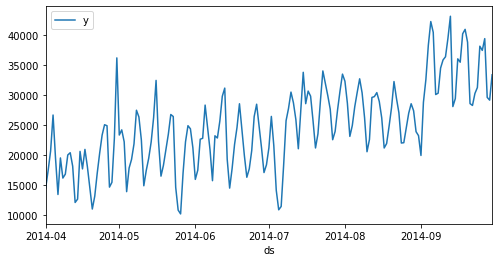

In [61]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlim(uberbyday.loc[0].values[0],uberbyday.loc[len(uberbyday)-1].values[0])
uberbyday.plot(x="ds", y="y", ax=ax);

Fig. 1: Plot of all Uber rides per day, April-September 2014. Some weekly seasonality visible (reflection of workweek commute travel?) and a rising trend that is relatively steady up to September, when the numbers rise pretty starkly.

# DATA PREPARATION 2: standardize the data

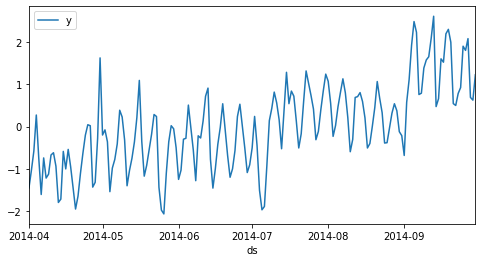

In [62]:
uberbyday['y'] = (uberbyday['y'] - uberbyday['y'].mean()) / uberbyday['y'].std()
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlim(uberbyday.loc[0].values[0],uberbyday.loc[len(uberbyday)-1].values[0])
uberbyday.plot(x="ds", y="y", ax=ax);

Fig. 2: Plot of all Uber rides per day standardized, April-September 2014.

# DATA ANALYSIS fit the uber rides data with the prophet model. 
# MODEL 1: trends and seasonality


In [63]:
simplem = Prophet()
simplem.fit(uberbyday)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [84]:
# why are these numbers just barely off from fed's results? What super-minute math did I mess up and where? It's not my standardizing, I think. 
forecast = simplem.make_future_dataframe(30)
forecast = simplem.predict(forecast)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
208,2014-10-26,1.540104,0.025818,1.350767,1.539987,1.540207,-0.856412,-0.856412,-0.856412,-0.856412,-0.856412,-0.856412,0.0,0.0,0.0,0.683692
209,2014-10-27,1.553291,0.284101,1.641428,1.553166,1.553400,-0.591027,-0.591027,-0.591027,-0.591027,-0.591027,-0.591027,0.0,0.0,0.0,0.962264
210,2014-10-28,1.566478,0.880050,2.238023,1.566346,1.566594,-0.027392,-0.027392,-0.027392,-0.027392,-0.027392,-0.027392,0.0,0.0,0.0,1.539086
211,2014-10-29,1.579664,1.226734,2.495819,1.579525,1.579789,0.316578,0.316578,0.316578,0.316578,0.316578,0.316578,0.0,0.0,0.0,1.896242
212,2014-10-30,1.592851,1.572702,2.880940,1.592706,1.592984,0.621960,0.621960,0.621960,0.621960,0.621960,0.621960,0.0,0.0,0.0,2.214811


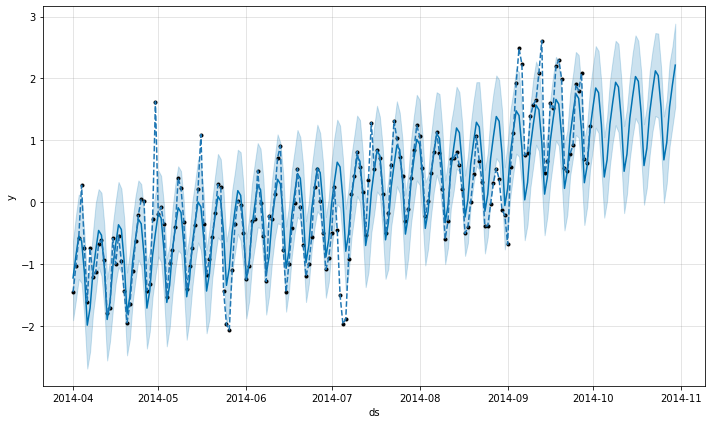

In [65]:
fig1 = simplem.plot(forecast)
pl.plot(uberbyday.ds, uberbyday.y, '--');

Fig.3: line plot(dotted) of standardized Uber rides per day (also represented in the black dots). The solid dark blue line represents the `simplem` model's prediction for uber rides per day, with the light blue representing upper and lower bounds for that prediction. The model results extend forward a month into the future, predicting continued growth and seasonality. There are some outlier days that don't fit the model's bounds but in terms of at least being within the upper/lower bounds it's pretty good?

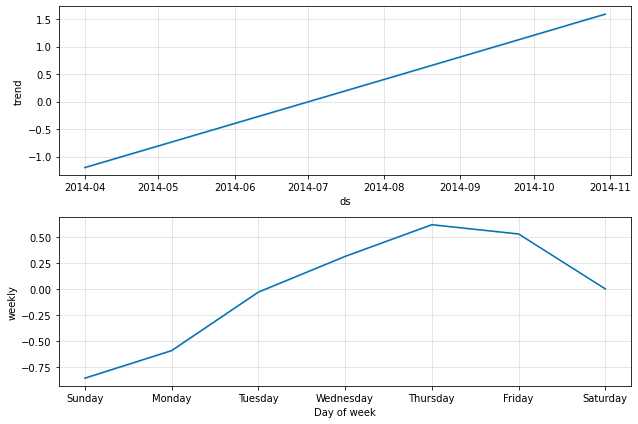

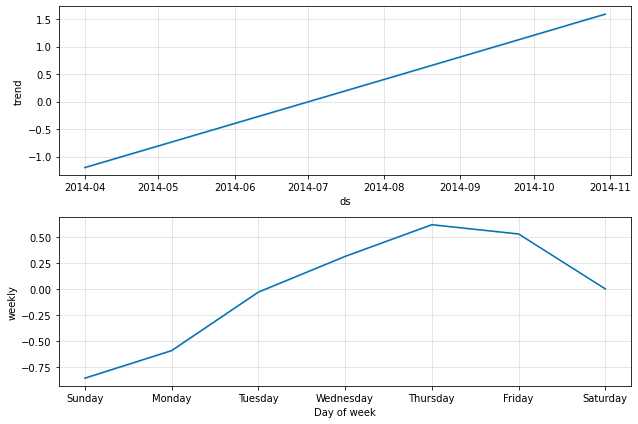

In [85]:
# this error started happening after I restarted the runtime? googling does not offer clues?
simplem.plot_components(forecast)

Fig. 4: Trend and seasonality plots for the `simplem` model. Trend is increasing over time, seasonality reflects weekly pattern (showing a steadily rising number of riders peaking on Thursday.

# DATA ANALYSIS: model validation
 Crossvaliate your model and create a function to evaluate the goodness of fit of your model. 
Use the chisquare per degree of freedom (also calle reduced chi square, note that this quantity has a theoretical expectation value of 1 for a perfect model): the chi square divided by the number of observations.Use 30 days for crossvalidation. The diagnostics function will return all that you need to calculate your reduce chi2. Howeve, we o not have the uncertainties to put them in the formula (we could create them from count statistics, but I wont ask you to) so set the uncertainties to 1. With unerestimated uncertainties this quantity is likely to be less than 1.

You can read about cross valiation for regression here https://robjhyndman.com/hyndsight/tscv/ (but do not set the period=1 or the process would take too long)

In [55]:
def rchi2(y, ytrue):
  # chi squared = ((y_actual=y_model)**2)/error
  # reduced chi squared = ((y_actual=y_model)**2)/total observations

  return np.sum(((ytrue-y)**2)/1/150) # cross validation ran 5 30-day forecasts, 5*30 = 150

In [87]:
cvresult_simplem = diagnostics.cross_validation(simplem, horizon ='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [56]:
# this value is also ~.01 off from Fed's result (0.4602355257526829), I am pretty sure I did this wrong but also what is happening
rchi2(cvresult_simplem['yhat'], cvresult_simplem['y'])

0.46172329566144815

# DATA ACQUISITION 2: download exogenous variable data. 

In [18]:
!pip install wwo_hist

In [19]:
from wwo_hist import retrieve_hist_data

In [20]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)


Mounted at /content/gdrive


In [21]:
cd /content/gdrive/MyDrive/MLTSA22

/content/gdrive/MyDrive/MLTSA22


In [72]:
frequency = 24 #fewquency in hours
start_date = '2014-04-01'
end_date = '2014-09-30'
api_key = pd.read_csv("my_apis.csv", header=None, index_col=0).iloc[1].values[0]
location_list = ['New+york,ny']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True)



Retrieving weather data for New+york,ny


Currently retrieving data for New+york,ny: from 2014-04-01 to 2014-04-30
Time elapsed (hh:mm:ss.ms) 0:00:01.723733
Currently retrieving data for New+york,ny: from 2014-05-01 to 2014-05-31
Time elapsed (hh:mm:ss.ms) 0:00:02.757530
Currently retrieving data for New+york,ny: from 2014-06-01 to 2014-06-30
Time elapsed (hh:mm:ss.ms) 0:00:03.634908
Currently retrieving data for New+york,ny: from 2014-07-01 to 2014-07-31
Time elapsed (hh:mm:ss.ms) 0:00:04.630582
Currently retrieving data for New+york,ny: from 2014-08-01 to 2014-08-31
Time elapsed (hh:mm:ss.ms) 0:00:05.649836
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:07.226435


export New+york,ny completed!




In [74]:
weather = pd.read_csv("New+york,ny.csv")
weather['ds'] = pd.to_datetime(weather['date_time']).dt.date
weather = weather[['ds','tempC', 'precipMM']]

In [76]:
uberweather = uberbyday.merge(weather, on='ds')

In [78]:
# OK, now I'm just really angry? How are these different integers? All the parens are in the right place!!
uberweather['tempC'] = (uberweather['tempC'] - uberweather['tempC'].mean()) / uberweather['tempC'].std()

uberweather['precipMM'] = (uberweather['precipMM'] - uberweather['precipMM'].mean()) / uberweather['precipMM'].std()
uberweather.head()

,ds,y,tempC,precipMM
0,2014-04-01,-1.449528,-1.738922,-0.563908
1,2014-04-02,-1.034719,-1.738922,-0.469021
2,2014-04-03,-0.577551,-1.380361,-0.563908
3,2014-04-04,0.274309,-2.814604,0.564196
4,2014-04-05,-0.744721,-2.276763,-0.173816


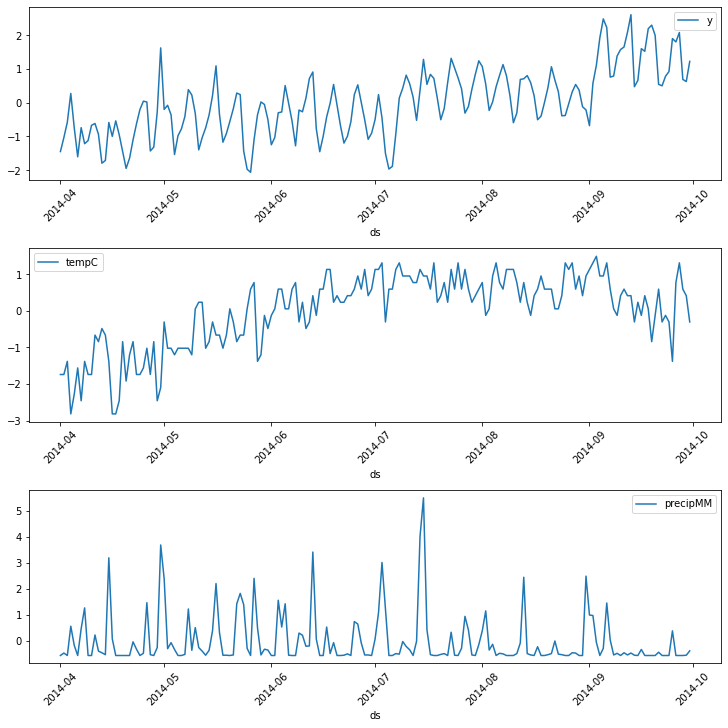

In [79]:
fig, ax = pl.subplots(3, figsize=(10,10),constrained_layout=True)
uberweather.plot(x='ds',y="y", ax=ax[0], rot=45)
uberweather.plot(x='ds',y="tempC", ax=ax[1],rot=45)
uberweather.plot(x='ds',y="precipMM", ax=ax[2],rot=45)

Fig. 5: plots of standarized Uber rides per day, standardized average temperature in Celsius, and standardized precipitation in millimeters for April-September 2014. Temperature shows a rising, then falling trend. Precipitation doesn't have quite the same consistency, but it does seem to start declining in September. 

   # MODEL 2: create a new Prophet model and add to it tempC and precipMM as regressors
Use the model method ```model.add_regressor()```. Call the model ```regrm```. Fit the model and cross valiate it. Plot the 2 models and calculate the reduced chi2 for each model and compare. Note that here you should not forecast, since you do not have the future values of the weather. If you wanted to go through the trouble to get future weather and forecast that is definitely a good extra credit!

In [80]:
regrm = Prophet()
regrm.add_regressor('tempC')
regrm.add_regressor('precipMM')

In [81]:
regrm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Weather Regressors Model')

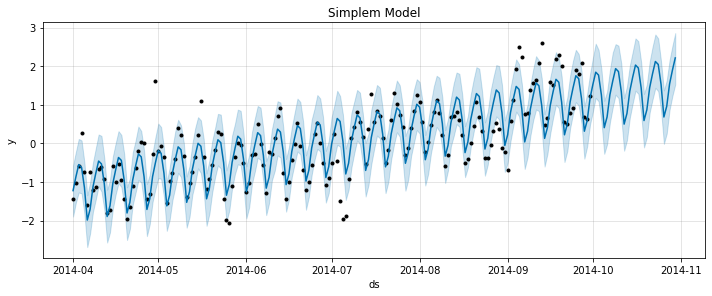

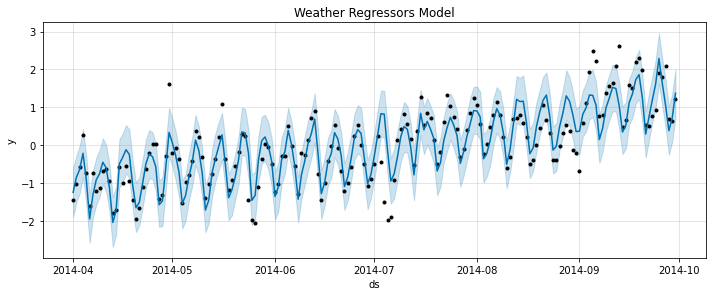

In [30]:
nowcast = regrm.predict(uberweather)
# method for customizing plots with titles found here: https://stackoverflow.com/questions/57982573/change-the-features-of-prophet-plot

fig1 = simplem.plot(forecast, figsize=(10, 4))
ax = fig1.gca()
ax.set_title('Simplem Model')

fig2 = regrm.plot(nowcast, figsize=(10,4))
ax2 = fig2.gca()
ax2.set_title('Weather Regressors Model')


Fig. 6: Plots for the basic trend/seasonality model and the model with weather added as a regressor. The model incorporating weather has a less uniform seasonality pattern (non-techical term: it's a little more spiky) but still seems to be not super-aligned to our data.

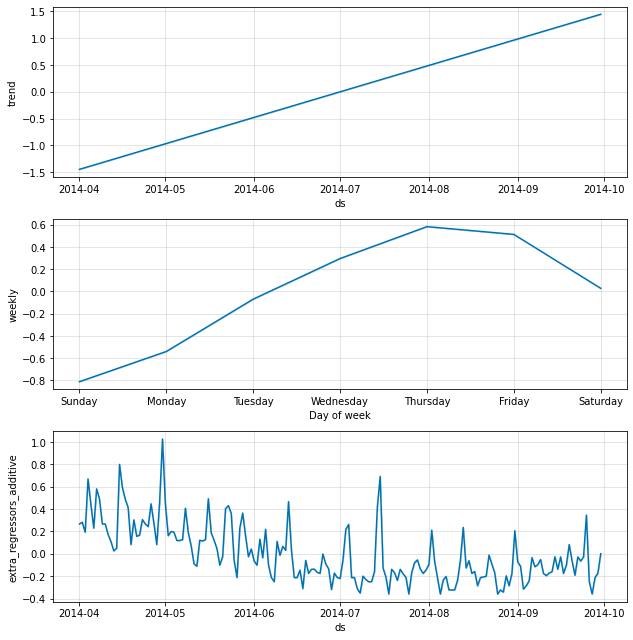

In [31]:
regrm.plot_components(nowcast);

Fig. 7: Trend, seasonality, and regressor plots for predictions made by the weather-regressor model. In trend and seasonality not seeing huge changes from `simplem`, added regressors seem to be presented as less significant over time?

In [32]:
regrm_crossval = diagnostics.cross_validation(regrm, horizon ='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
# not sure if I'm supposed to be making a new rchi2 function for each model or use the same one. 

rchi2(cvresult_simplem['yhat'], cvresult_simplem['y']), rchi2(regrm_crossval['yhat'], regrm_crossval['y'])

(0.46172329566144815, 0.47455596482755086)

# MODEL 3 add holidays

In [35]:
regholm = Prophet()
regholm.add_regressor('tempC')
regholm.add_regressor('precipMM')
regholm.add_country_holidays(country_name='US')
regholm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Weather Regressors and Holidays Model')

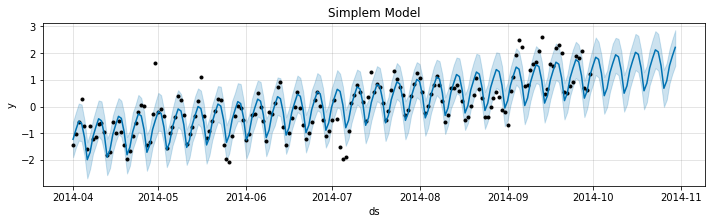

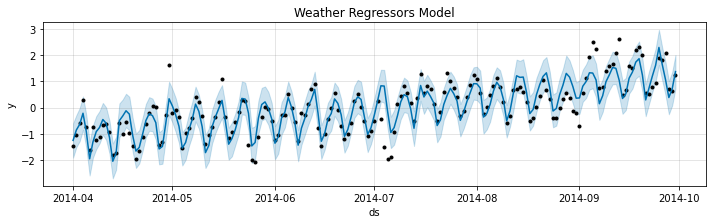

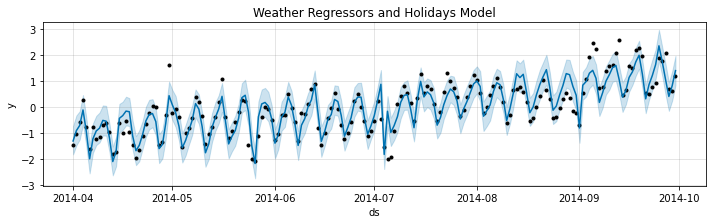

In [38]:
holidays = regholm.predict(uberweather)

fig1 = simplem.plot(forecast, figsize=(10,3))
ax = fig1.gca()
ax.set_title('Simplem Model')

fig2 = regrm.plot(nowcast, figsize=(10,3))
ax2 = fig2.gca()
ax2.set_title('Weather Regressors Model')

fig3 = regholm.plot(holidays, figsize=(10,3))
ax3 = fig3.gca()
ax3.set_title('Weather Regressors and Holidays Model')

Fig. 8: plots of predictions from the weather and holidays model for our simple trend/seasonality model, weather regressions, and weather regressions plus US holidays. This does actually start to show some improvement? Some of the farther-outlier dates like drops around 4th of July weekend, Labor Day, and Memorial Day are captured by the model's prediction. 

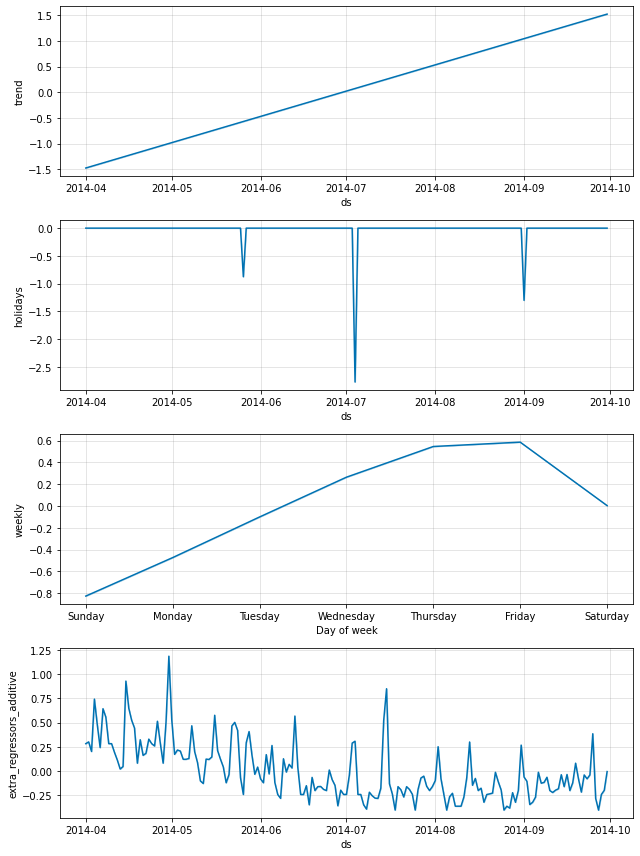

In [39]:
regholm.plot_components(holidays);

Fig. 9: Trend, seasonality, weather regressors, and holidays plotted from our holidays-and-weather incorporating model. Seasonality does seem to have shifted a little in this model with total rides on Thursdays and Fridays being a bit closer in value. Major holidays are reflected, with the 4th of July apparently contributing to a much bigger drop than Memorial and Labor Day.

In [40]:
holiday_crossval = diagnostics.cross_validation(regholm, horizon='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [41]:
# is this supposed to go down? I feel like I did something really wrong here
rchi2(cvresult_simplem['yhat'], cvresult_simplem['y']), rchi2(regrm_crossval['yhat'], regrm_crossval['y']), rchi2(holiday_crossval['yhat'], holiday_crossval['y'])

(0.46172329566144815, 0.47455596482755086, 0.4050179801307614)

# MODEL 4: this whole thing can be done with MCMC optimization in a fully bayesian framework. 
Add the argument mcmc_samples=5000 to Propher in your next model and see how it goes. Make the usual plots and calculate the reduced chi2 one last time

In [42]:
regmcmc = Prophet(mcmc_samples=5000)
regmcmc.add_regressor('tempC')
regmcmc.add_regressor('precipMM')
regmcmc.add_country_holidays(country_name='US')
regmcmc.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
mcmc_pred = regmcmc.predict(uberweather)

Text(0.5, 1.0, 'Weather, Holidays, and Monte Carlo Markov Chain Model')

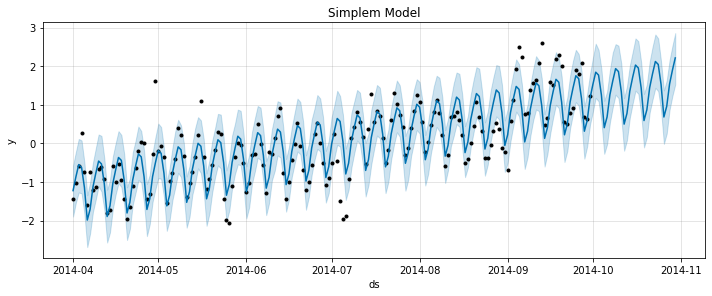

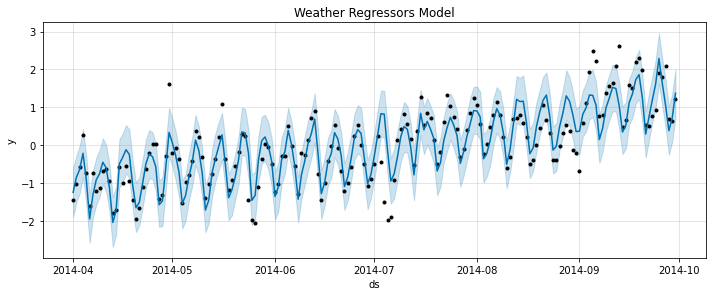

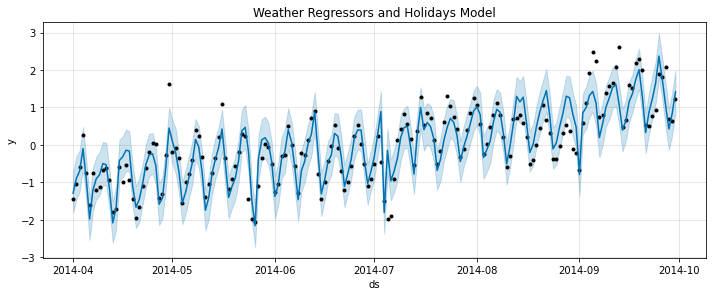

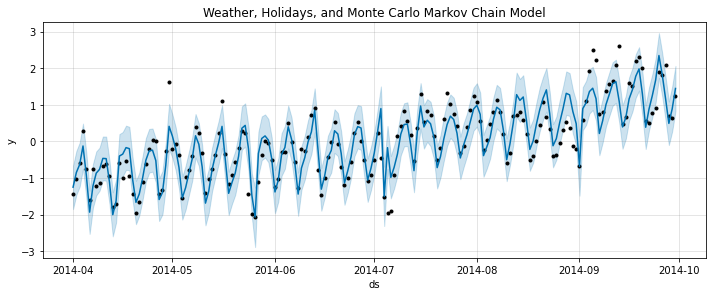

In [44]:
fig1 = simplem.plot(forecast, figsize=(10,4))
ax = fig1.gca()
ax.set_title('Simplem Model')

fig2 = regrm.plot(nowcast, figsize=(10,4))
ax2 = fig2.gca()
ax2.set_title('Weather Regressors Model')

fig3 = regholm.plot(holidays, figsize=(10,4))
ax3 = fig3.gca()
ax3.set_title('Weather Regressors and Holidays Model')

fig4 = regmcmc.plot(mcmc_pred, figsize=(10,4))
ax4 = fig4.gca()
ax4.set_title('Weather, Holidays, and Monte Carlo Markov Chain Model')

Fig. 10: Plots for our first 3 models and our MCMC-holidays-and-weather model. This also looks a bit closer in terms of the actual data being within the upper/lower bounds? 

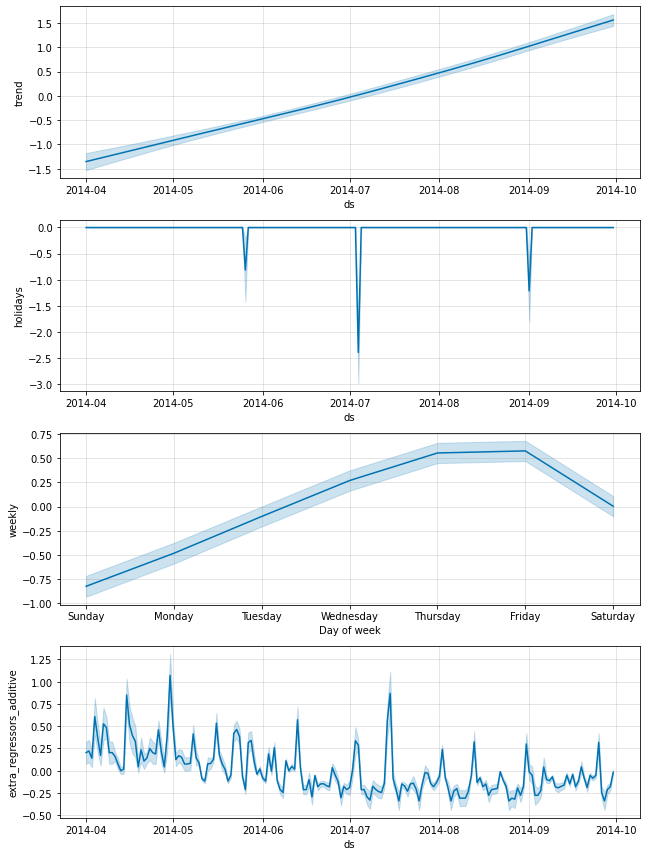

In [45]:
regmcmc.plot_components(mcmc_pred);

Fig. 11: Plot components (trend, seasonality, weather regressors, holidays) for our `regmcmc` model. MCMC sampling is visible as uncertainty in these plots.

In [47]:
mcmc_crossval = diagnostics.cross_validation(regmcmc, '30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [50]:
# I'm definitely doing something wrong here but I don't know what it is
rchi2(cvresult_simplem['yhat'], cvresult_simplem['y']), rchi2(regrm_crossval['yhat'], regrm_crossval['y']), rchi2(holiday_crossval['yhat'], holiday_crossval['y']), rchi2(mcmc_crossval['yhat'],mcmc_crossval['y'])

(0.46172329566144815,
 0.47455596482755086,
 0.4050179801307614,
 0.4499593085570953)

# Extra Credit
There are two packages with similar functionalities. As extra credit, repeat some of the steps of this analysis with either: Tensorflow timeseries modeling https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html or https://github.com/wwrechard/pydlm